In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
import pandas as pd
# from facenet_pytorch import InceptionResnetV1, fixed_image_standardization, training
# a = []
# while(1):
#     a.append(1)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%%time
zip_path = '/content/drive/My Drive/Colab Notebooks/allimgs_face2.zip'
!cp "{zip_path}" .
!unzip -q allimgs_face2.zip 
!rm allimgs_face2.zip

CPU times: user 44.2 ms, sys: 13 ms, total: 57.2 ms
Wall time: 12.9 s


In [4]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_pairs_race_split.csv')

winners_train = data[[data.columns[1], data.columns[2]]]
losers_train = data[[data.columns[3], data.columns[4]]]

test_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_pairs_race_split.csv')
winners_test = test_data[[test_data.columns[1], test_data.columns[2]]]
losers_test = test_data[[test_data.columns[3], test_data.columns[4]]]

val_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/val_pairs_race_split.csv')
winners_val = val_data[[val_data.columns[1], val_data.columns[2]]]
losers_val = val_data[[val_data.columns[3], val_data.columns[4]]]

In [5]:
# # Get train and test data for classification
train_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_on_cand.csv')
new_paths = []
for path, winner in zip(train_df[train_df.columns[2]].tolist(), train_df[train_df.columns[3]].tolist()):
    words = path.split('/')
    new_path = 'allimgs_face/'+words[1]+'/'+words[2]
    if '.webp' not in new_path:
        new_paths.append([new_path, winner])
train_df = pd.DataFrame(new_paths) 
train_df[train_df.columns[1]]= train_df[train_df.columns[1]].astype(float)
# train_df = train_df.sample(frac=1).reset_index(drop=True)


test_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_on_cand.csv')
new_paths_test = []
for path, winner in zip(test_df[test_df.columns[2]].tolist(), test_df[test_df.columns[3]].tolist()):
    words = path.split('/')
    new_path = 'allimgs_face/'+words[1]+'/'+words[2]
    if '.webp' not in new_path:
        new_paths_test.append([new_path, winner])

test_df = pd.DataFrame(new_paths_test)    
test_df[test_df.columns[1]]= test_df[test_df.columns[1]].astype(float)   

val_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/val_on_cand.csv')
new_paths_val = []
for path, winner in zip(val_df[val_df.columns[2]].tolist(), val_df[val_df.columns[3]].tolist()):
    words = path.split('/')
    new_path = 'allimgs_face/'+words[1]+'/'+words[2]
    if '.webp' not in new_path:
        new_paths_val.append([new_path, winner])


val_df = pd.DataFrame(new_paths_val)    
val_df[val_df.columns[1]]= val_df[val_df.columns[1]].astype(float)   
# val_df

In [6]:
# Create a dataloader class
class DatasetFaces_Rank(Dataset):
    
    def __init__(self, df, transform=None):
        self.data = df
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):

        img_name = self.data[self.data.columns[0]].iloc[index]
        # img_name = img_name.split('/')

   

        image = Image.open("/content/"+img_name).convert('RGB')
        # label = self.data[self.data.columns[1]].iloc[index]
        if self.transform is not None:
            image = self.transform(image)
        else:
            print("TRANSFORM FAILED")
        return image
  
# Create a dataloader class
class DatasetFaces_classify(Dataset):
    
    def __init__(self, df, transform=None):
        self.data = df
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):

        img_name = self.data[self.data.columns[0]].iloc[index]
        # img_name = img_name.split('/')

   

        image = Image.open("/content/"+img_name).convert('RGB')
        label = self.data[self.data.columns[1]].iloc[index]
        if self.transform is not None:
            image = self.transform(image)
        else:
            print("TRANSFORM FAILED")
        return image,label

In [7]:
# Create a transform for data prep
transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

# Ranking
extraction_dataset_win = DatasetFaces_Rank(winners_train, transform)
extraction_loader_win = torch.utils.data.DataLoader(extraction_dataset_win, batch_size=1,shuffle=False, num_workers=1)
extraction_dataset_los = DatasetFaces_Rank(losers_train, transform)
extraction_loader_los = torch.utils.data.DataLoader(extraction_dataset_los, batch_size=1,shuffle=False, num_workers=1)

extraction_dataset_win_test = DatasetFaces_Rank(winners_test, transform)
extraction_loader_win_test = torch.utils.data.DataLoader(extraction_dataset_win_test, batch_size=1,shuffle=False, num_workers=1)
extraction_dataset_los_test = DatasetFaces_Rank(losers_test, transform)
extraction_loader_los_test = torch.utils.data.DataLoader(extraction_dataset_los_test, batch_size=1,shuffle=False, num_workers=1)

extraction_dataset_win_val = DatasetFaces_Rank(winners_val, transform)
extraction_loader_win_val = torch.utils.data.DataLoader(extraction_dataset_win_val, batch_size=1,shuffle=False, num_workers=1)
extraction_dataset_los_val = DatasetFaces_Rank(losers_val, transform)
extraction_loader_los_val = torch.utils.data.DataLoader(extraction_dataset_los_val, batch_size=1,shuffle=False, num_workers=1)

# Classification
train_dataset = DatasetFaces_classify(train_df, transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,shuffle=False, num_workers=1)

test_dataset = DatasetFaces_classify(test_df, transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,shuffle=False, num_workers=1)


val_dataset = DatasetFaces_classify(val_df, transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1,shuffle=False, num_workers=1)

allimgs_face/David Cameron Conservative/E7dALt_-_400x400.jpg


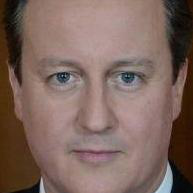

In [9]:
file_name = winners_train.iloc[0]
print(file_name[0])
img = Image.open('/content/'+ file_name[0])
img

In [10]:
# Load model and create model
model = models.vgg16(pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(25088, 4096),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.Dropout(0.5),
    nn.Linear(4096, 1),
    nn.Sigmoid()
)

# weights = torch.load('/content/drive/My Drive/Colab Notebooks/model weights/imagenet_vgg_3conv_best.pl')
# model.load_state_dict(weights)
feature_extractor_first_layer = model.features[:30]
feature_extractor_second_layer = model.features[:28]
feature_extractor_third_layer = model.features[:26]

if torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("done")
print(model)
print(feature_extractor_first_layer)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



using device: cuda
done
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride

In [11]:
win_set = []
los_set = []
with torch.no_grad():
        for data in extraction_loader_win:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            inputs = data
            inputs = inputs.to(device)
            l29 = feature_extractor_first_layer(inputs)
            l27 = feature_extractor_second_layer(inputs)
            l25 = feature_extractor_third_layer(inputs)
            m = nn.MaxPool2d(16, stride=1)
            l29 = m(l29)
            l27 = m(l27)
            l25 = m(l25)
            win_set.append([l25.cpu().numpy(),l27.cpu().numpy(),l29.cpu().numpy(), True])
            # break
            
with torch.no_grad():
        for data in extraction_loader_los:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            inputs = data
            inputs = inputs.to(device)
            l29 = feature_extractor_first_layer(inputs)
            l27 = feature_extractor_second_layer(inputs)
            l25 = feature_extractor_third_layer(inputs)
            m = nn.MaxPool2d(16, stride=1)
            l29 = m(l29)
            l27 = m(l27)
            l25 = m(l25)
            los_set.append([l25.cpu().numpy(),l27.cpu().numpy(),l29.cpu().numpy(), False])


In [12]:
win_df = pd.DataFrame(win_set)
win_df.to_pickle('/content/drive/My Drive/Colab Notebooks/NF_VGG_imagenet_win_set.pl')
los_df = pd.DataFrame(los_set)
los_df.to_pickle('/content/drive/My Drive/Colab Notebooks/NF_VGG_imagenet_los_set.pl')

In [13]:
win_set_test = []
los_set_test = []
with torch.no_grad():
        for data in extraction_loader_win_test:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            inputs = data
            inputs = inputs.to(device)
            l29 = feature_extractor_first_layer(inputs)
            l27 = feature_extractor_second_layer(inputs)
            l25 = feature_extractor_third_layer(inputs)
            m = nn.MaxPool2d(16, stride=1)
            l29 = m(l29)
            l27 = m(l27)
            l25 = m(l25)
            win_set_test.append([l25.cpu().numpy(),l27.cpu().numpy(),l29.cpu().numpy(), True])
with torch.no_grad():
        for data in extraction_loader_los_test:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            inputs = data
            inputs = inputs.to(device)
            l29 = feature_extractor_first_layer(inputs)
            l27 = feature_extractor_second_layer(inputs)
            l25 = feature_extractor_third_layer(inputs)
            m = nn.MaxPool2d(16, stride=1)
            l29 = m(l29)
            l27 = m(l27)
            l25 = m(l25)
            los_set_test.append([l25.cpu().numpy(),l27.cpu().numpy(),l29.cpu().numpy(), False])
  

In [14]:
win_df_test = pd.DataFrame(win_set_test)
win_df_test.to_pickle('/content/drive/My Drive/Colab Notebooks/NF_VGG_imagenet_win_set_test.pl')
los_df_test = pd.DataFrame(los_set_test)
los_df_test.to_pickle('/content/drive/My Drive/Colab Notebooks/NF_VGG_imagenet_los_set_test.pl')

In [17]:
win_set_val = []
los_set_val = []
with torch.no_grad():
        for data in extraction_loader_win_val:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            inputs = data
            inputs = inputs.to(device)
            l29 = feature_extractor_first_layer(inputs)
            l27 = feature_extractor_second_layer(inputs)
            l25 = feature_extractor_third_layer(inputs)

            m = nn.MaxPool2d(16, stride=1)
            l29 = m(l29)
            l27 = m(l27)
            l25 = m(l25)
            win_set_val.append([l25.cpu().numpy(),l27.cpu().numpy(),l29.cpu().numpy(), True])
print("HALFWAY")           
with torch.no_grad():
        for data in extraction_loader_los_val:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            inputs = data
            inputs = inputs.to(device)
            l29 = feature_extractor_first_layer(inputs)
            l27 = feature_extractor_second_layer(inputs)
            l25 = feature_extractor_third_layer(inputs)

            m = nn.MaxPool2d(16, stride=1)
            l29 = m(l29)
            l27 = m(l27)
            l25 = m(l25)
            los_set_val.append([l25.cpu().numpy(),l27.cpu().numpy(),l29.cpu().numpy(), False])
  

HALFWAY


In [18]:
win_df_val = pd.DataFrame(win_set_val)
win_df_val.to_pickle('/content/drive/My Drive/Colab Notebooks/NF_VGG_imagenet_win_set_val.pl')
los_df_val = pd.DataFrame(los_set_val)
los_df_val.to_pickle('/content/drive/My Drive/Colab Notebooks/NF_VGG_imagenet_los_set_val.pl')

In [20]:
train_features = []
test_features = []
val_features = []

with torch.no_grad():
        for data in train_loader:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            inputs, label = data
            inputs = inputs.to(device)
            l29 = feature_extractor_first_layer(inputs)
            l27 = feature_extractor_second_layer(inputs)
            l25 = feature_extractor_third_layer(inputs)
            m = nn.MaxPool2d(16, stride=1)
            l29 = m(l29)
            l27 = m(l27)
            l25 = m(l25)
            train_features.append([l25.cpu().numpy(),l27.cpu().numpy(),l29.cpu().numpy(), label])
       
with torch.no_grad():
        for data in test_loader:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            inputs, label = data
            inputs = inputs.to(device)
            l29 = feature_extractor_first_layer(inputs)
            l27 = feature_extractor_second_layer(inputs)
            l25 = feature_extractor_third_layer(inputs)
            m = nn.MaxPool2d(16, stride=1)
            l29 = m(l29)
            l27 = m(l27)
            l25 = m(l25)
            test_features.append([l25.cpu().numpy(),l27.cpu().numpy(),l29.cpu().numpy(), label])
with torch.no_grad():
        for data in val_loader:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            inputs, label = data
            inputs = inputs.to(device)
            l29 = feature_extractor_first_layer(inputs)
            l27 = feature_extractor_second_layer(inputs)
            l25 = feature_extractor_third_layer(inputs)
            m = nn.MaxPool2d(16, stride=1)
            l29 = m(l29)
            l27 = m(l27)
            l25 = m(l25)
            val_features.append([l25.cpu().numpy(),l27.cpu().numpy(),l29.cpu().numpy(), label])
            
            


In [21]:
train_features = pd.DataFrame(train_features)
train_features.to_pickle('/content/drive/My Drive/Colab Notebooks/NF_vgg16_imagenet_train.pl')
test_features = pd.DataFrame(test_features)
test_features.to_pickle('/content/drive/My Drive/Colab Notebooks/NF_vgg16_imagenet_test.pl')
val_features = pd.DataFrame(val_features)
val_features.to_pickle('/content/drive/My Drive/Colab Notebooks/NF_vgg16_imagenet_val.pl')

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


,0,1
0,"[[[[0. 0. 0. 0. 0. 0. 0.], [0. 0. 0. 0. 0. 0. ...",True
1,"[[[[0. 0. 0. 0. 0. 0. 0.], [0. 0. 0. 0. 0. 0. ...",True
2,"[[[[0. 0. 0. 0. 0. 0. 0.], [0. 0. 0. 0. 0. 0. ...",True
3,"[[[[0. 0. 0. 0. 0. 0. 0.], [0. 0. 0. 0. 0. 0. ...",True
4,"[[[[0. 0. 0. 0. 0. 0. 0.], [0. 0. 0. 0. 0. 0. ...",True
...,...,...
992,[[[[0. 0.41331547 1.2869496 1.4176927...,True
993,[[[[0. 0.41331547 1.2869496 1.4176927...,True
994,"[[[[0. 0. 0. 0. 0. 0. 0.], [0. 0. 0. 0. 0. 0. ...",True
995,"[[[[0. 0. 0. 0. 0. 0. 0.], [0. 0. 0. 0. 0. 0. ...",True
